In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns

In [2]:
# нормализация массива
def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)


def to_one_hot(Y):
    n_col = np.amax(Y) + 1
    binarized = np.zeros((len(Y), n_col))
    for i in range(len(Y)):
        binarized[i, Y[i]] = 1.
    return binarized


# преобразование массива в необходимый вид
def from_one_hot(Y):
    arr = np.zeros((len(Y), 1))

    for i in range(len(Y)):
        hot = Y[i]
        for j in range(len(hot)):
            if hot[j] == 1:
                arr[i] = j + 1
    return arr


def sigmoid(var):
    return 1 / (1 + np.exp(-var))

In [3]:
class TwoLayerNet:
    """
    Class for neutral net with two layers
    """

    def __init__(self, neuron_numb, steps, learning_rate):
        self.learning_rate = learning_rate
        self.steps = steps
        self.neuron_numb = neuron_numb
        self.w0 = (1, 1)
        self.w1 = (1, 1)
        self.fit_flag = False

    # сигмоида и ее производная
    @staticmethod
    def act_func(var):
        return 1 / (1 + np.exp(-var))

    @staticmethod
    def act_func_deriv(var):
        return var * (1 - var)

    def fit(self, X_train, y_train):
        self.fit_flag = True
        # присваевание случайных весов
        self.w0 = 2 * np.random.random((X_train.shape[1], self.neuron_numb)) - 1  # для входного слоя
        self.w1 = 2 * np.random.random((self.neuron_numb, y_train.shape[1])) - 1  # для внутреннего слоя

        # процесс обучения
        accuracy = 0
        for i in range(self.steps):
            # прямое распространение(feed forward)
            layer0 = X_train
            layer1 = self.act_func(np.dot(layer0, self.w0))
            layer2 = self.act_func(np.dot(layer1, self.w1))

            # обратное распространение(back propagation) с использованием градиентного спуска
            layer2_error = y_train - layer2  # производная функции потерь = производная квадратичных потерь
            layer2_delta = layer2_error * self.act_func_deriv(layer2)

            layer1_error = layer2_delta.dot(self.w1.T)
            layer1_delta = layer1_error * self.act_func_deriv(layer1)
            # коррекция
            self.w1 += layer1.T.dot(layer2_delta) * self.learning_rate
            self.w0 += layer0.T.dot(layer1_delta) * self.learning_rate
            # метрика модели
            error = np.mean(np.abs(layer2_error))
            accuracy = (1 - error) * 100

        return accuracy

    def predict(self, X_test, y_test):
        if self.fit_flag:
            # прямое распространение(feed forward)
            layer0_t = X_test
            layer1_t = self.act_func(np.dot(layer0_t, self.w0))
            layer2_t = self.act_func(np.dot(layer1_t, self.w1))
            layer2_error_t = y_test - layer2_t

            # метрика модели
            error_t = np.mean(np.abs(layer2_error_t))
            accuracy_t = (1 - error_t) * 100
        else:
            accuracy_t = None

        return accuracy_t

In [5]:
# Подготовка тренировочных данных
# получения данных из csv файла. укажите здесь путь к файлу Iris.csv
iris_data = pd.read_csv("Iris.csv")

# замена текстовых значений на цифровые
iris_data['Species'].replace(['Iris-setosa', 'Iris-virginica', 'Iris-versicolor'], [0, 1, 2], inplace=True)

# формирование входных данных
columns = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
x = pd.DataFrame(iris_data, columns=columns)
x = normalize(x.values)

# формирование выходных данных(результатов)
columns = ['Species']
y = pd.DataFrame(iris_data, columns=columns)
y = y.values
y = y.flatten()
y = to_one_hot(y)

# Разделение данных на тренировочные и тестовые
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

net = TwoLayerNet(5, 1000, 0.05)
acc_train = net.fit(X_train, y_train)
print(f"Точность сети на трейне {acc_train}")

Точность сети на трейне 89.81117940084987


In [6]:
res = pd.DataFrame(columns=['num_neurons', 'steps', 'learning_rate', 'accurancy'])
for num_neurons in np.arange(3, 10):
    for learning_rate in np.arange(0.01, 0.5, 0.01):
        for steps in np.arange(500, 2000, 500):
            net = TwoLayerNet(num_neurons, steps, learning_rate)
            acc_train = net.fit(X_train, y_train)
            res.loc[len(res)] = [num_neurons, steps, learning_rate, acc_train]

In [7]:
res.shape

(1029, 4)

In [11]:
res[['num_neurons', 'learning_rate', 'accurancy']].head(5)

,num_neurons,learning_rate,accurancy
0,3.0,0.01,64.918481
1,3.0,0.01,73.680653
2,3.0,0.01,77.282828
3,3.0,0.02,74.388311
4,3.0,0.02,78.035029


In [15]:
res['num_neurons'].min()

3.0

/var/folders/t8/rf5y38yd2pg3fw8v0rwbkqd80000gp/T/ipykernel_29693/2215795789.py:3: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


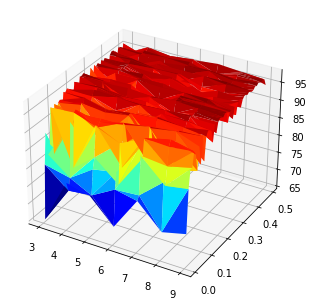

In [25]:
from matplotlib import cm
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(res.num_neurons, res.learning_rate, res.accurancy, cmap=cm.jet, linewidth=0.2)
plt.show()

/var/folders/t8/rf5y38yd2pg3fw8v0rwbkqd80000gp/T/ipykernel_29693/3039305350.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


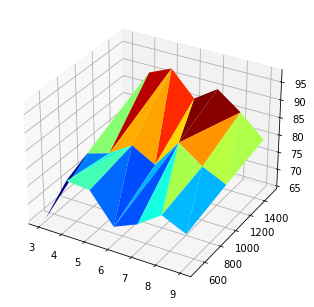

In [27]:
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(res.num_neurons, res.steps, res.accurancy, cmap=cm.jet, linewidth=0.2)
plt.show()